In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import pcmdpy_gpu as ppy
from tqdm import tqdm
%matplotlib inline

In [2]:
plt.style.use('seaborn-poster')


\begin{align}
\frac{S}{N} &\approx \frac{\sigma_{int}}{\Delta m_{shot noise}}\\
\sigma_{int} &: \textrm{Computed from Simulations}\\
f_{pix} &\sim \mathcal{Poiss}(\bar{r} t_{exp})\\
m_{pix} &= -2.5\log_{10}(f_{pix}) + c\\
\Delta m_{shot noise} &\approx \left|\frac{\partial m_{pix}}{\partial f_{pix}}\right|\Delta f_{pix} = \frac{2.5}{\ln{}10\, f_{pix}}\sqrt{f_{pix}}\\
&\approx \frac{1.08}{\sqrt{\bar{r} t_{exp}}}\\
\frac{S}{N} &\approx \frac{\sigma_{int} \sqrt{\bar{r} t_{exp}}}{1.08}\\
t_{exp} &\approx \frac{(1.08\frac{S}{N})^2}{\sigma_{int}^2 \bar{r}}
\end{align}

In [3]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f, mag_system='ab')
driv = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
exposures = np.array([3235.0, 3620.0])

In [5]:
gal_disk = ppy.galaxy.CustomGalaxy(
    'single',
    'single',
    'tau',
    'variable',
)
gal_bulge = ppy.galaxy.CustomGalaxy(
    'single',
    'single',
    'tau',
    'variable',
)

In [6]:
gal_disk.set_params(np.array([-0.5, -2.0, 1.8, 3.2, 24.42]))
imf_disk, mags_disk = iso_model.model_galaxy(gal_disk, mag_system='ab')
flux_disk = np.array([filt.mag_to_counts(m) for filt,m in zip(f, mags_disk)])
pcmd_disk = driv.simulate(gal_disk, 512, psf=True, shot_noise=False, mag_system='ab')[0]
mags_disk = ppy.utils.pcmd_to_mags(pcmd_disk)

In [7]:
gal_bulge.set_params(np.array([0.0, -2.0, 3.7, 2.5, 24.42]))
imf_bulge, mags_bulge = iso_model.model_galaxy(gal_bulge, mag_system='ab')
flux_bulge = np.array([filt.mag_to_counts(m) for filt,m in zip(f, mags_bulge)])
pcmd_bulge = driv.simulate(gal_bulge, 512, psf=True, shot_noise=False, mag_system='ab')[0]
mags_bulge = ppy.utils.pcmd_to_mags(pcmd_bulge)

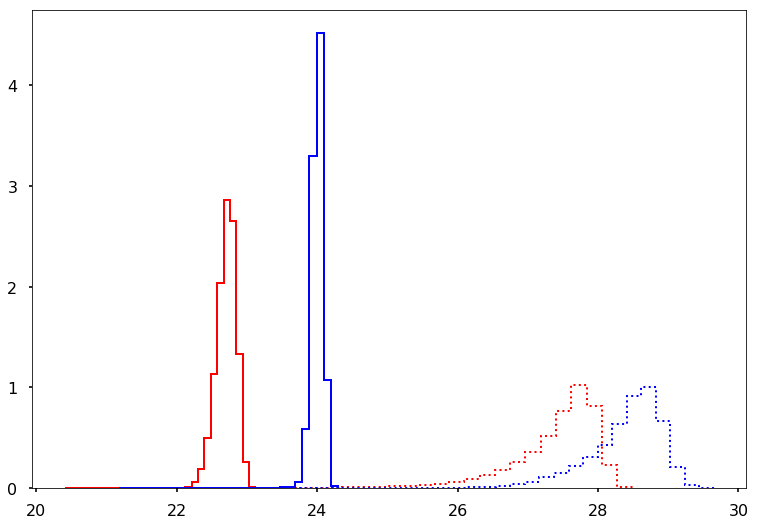

In [8]:
plt.hist(mags_disk[0], histtype='step', bins=30, density=True, ls=':', lw=2, color='r')
plt.hist(mags_disk[1], histtype='step', bins=30, density=True, ls=':', lw=2, color='b')
plt.hist(mags_bulge[0], histtype='step', bins=30, density=True, ls='-', lw=2, color='r')
plt.hist(mags_bulge[1], histtype='step', bins=30, density=True, ls='-', lw=2, color='b');

In [9]:
def sigma_int(base_gal, logNpix):
    params = np.array(base_gal._params)
    params[2] = logNpix
    base_gal.set_params(params)
    pcmd = driv.simulate(base_gal, 1024, psf=True, shot_noise=False, mag_system='ab')[0]
    mags = ppy.utils.pcmd_to_mags(pcmd)
    return np.std(mags, axis=-1)

In [25]:
sigmas_disk_F814W, sigmas_disk_F475W = [], []
sigmas_bulge_F814W, sigmas_bulge_F475W = [], []
logNpixs = np.linspace(1, 8, 20)
for logNpix in tqdm(logNpixs):
    a, b = sigma_int(gal_disk, logNpix)
    sigmas_disk_F814W.append(a)
    sigmas_disk_F475W.append(b)    
    a, b = sigma_int(gal_bulge, logNpix)
    sigmas_bulge_F814W.append(a)
    sigmas_bulge_F475W.append(b)    

100%|██████████| 20/20 [01:50<00:00,  5.94s/it]


In [26]:
np.array(sigmas_disk_F814W) / np.array(sigmas_bulge_F814W)

array([1.03249888, 1.05303478, 1.06565861, 1.06634902, 1.08256833,
       1.11749739, 1.13840527, 1.1680276 , 1.20286537, 1.25871438,
       1.19141723, 1.14161295, 1.19580208, 1.20289733, 1.15336123,
       1.21790082, 1.18915407, 1.16603188, 1.19982971, 1.1845937 ])

In [27]:
10**1.8 * (1.0 / gal_disk.distance_model.d_mpc)**2

107.64652136298331

In [28]:
10**3.7 * (1.0 / gal_disk.distance_model.d_mpc)**2

8550.667128846822

In [29]:
rbar_disk = np.array([(imf_disk * flux_disk[i]).sum() for i in range(2)]) / exposures
rbar_bulge = np.array([(imf_bulge * flux_bulge[i]).sum() for i in range(2)]) / exposures

In [30]:
exp_disk = (1.08*5)**2 / (np.array(sigmas_disk_F814W)**2 * rbar_disk[0])
Npix_disk = np.log10([1.08e2, 1.08e4, 1.08e6])
exp_disk_points = (1.08*5)**2 / (np.array([sigma_int(gal_disk, N)[0] for N in Npix_disk])**2 * rbar_disk[0])

In [31]:
exp_bulge = (1.08*5)**2 / (np.array(sigmas_bulge_F814W)**2 * rbar_bulge[0])
Npix_bulge = np.log10([8.6e3, 8.6e5, 8.6e7])
exp_bulge_points = (1.08*5)**2 / (np.array([sigma_int(gal_bulge, N)[0] for N in Npix_bulge])**2 * rbar_bulge[0])

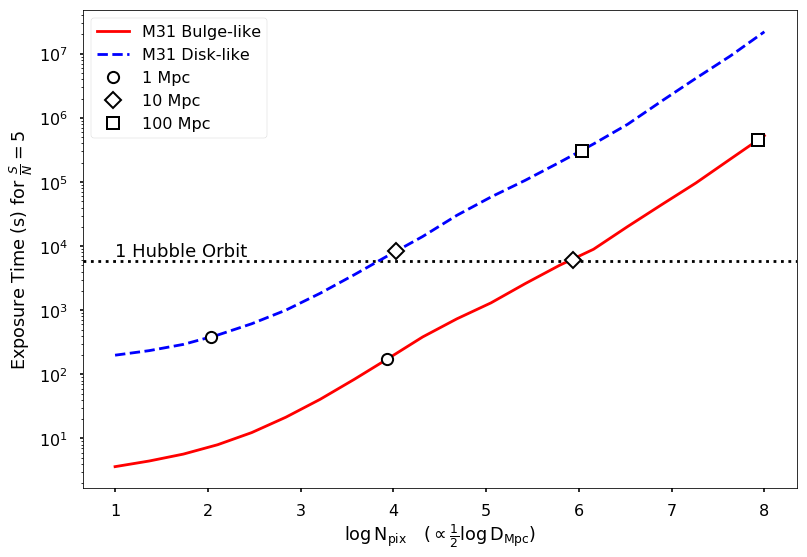

In [35]:
fig, ax = plt.subplots()
ax.plot(logNpixs, exp_bulge, color='r', ls='-', label='M31 Bulge-like')
ax.plot(logNpixs, exp_disk, color='b', ls='--', label='M31 Disk-like')

kwargs_1 = {'marker': 'o', 'mfc': 'w', 'mec': 'k', 'mew': 2, 'ls': ''}
ax.plot(Npix_bulge[0], exp_bulge_points[0], label='1 Mpc', **kwargs_1)
ax.plot(Npix_disk[0], exp_disk_points[0], **kwargs_1)

kwargs_10 = {'marker': 'D', 'mfc': 'w', 'mec': 'k', 'mew': 2, 'ls': ''}
ax.plot(Npix_bulge[1], exp_bulge_points[1], label='10 Mpc', **kwargs_10)
ax.plot(Npix_disk[1], exp_disk_points[1], **kwargs_10)

kwargs_100 = {'marker': 's', 'mfc': 'w', 'mec': 'k', 'mew': 2, 'ls': ''}
ax.plot(Npix_bulge[2], exp_bulge_points[2], label='100 Mpc', **kwargs_100)
ax.plot(Npix_disk[2], exp_disk_points[2], **kwargs_100)

ax.axhline(y=5760, ls=':', color='k', zorder=-1)
ax.text(1, 6000, '1 Hubble Orbit', verticalalignment='bottom', horizontalalignment='left', fontsize=18)
ax.legend(loc=0)

ax.set_yscale('log')
ax.set_xlabel(r'$\log\,\mathrm{N_{pix}} \quad (\propto \frac{1}{2} \log\, \mathrm{D_{Mpc}})$')
ax.set_ylabel(r'Exposure Time (s) for $\frac{S}{N} = 5$')

plt.savefig('figures/paper1/exposure_time.pdf')